# Largest diameter of a shape

Example by Pierre Lemaire.

The goal of this notebook is to show an example of a **non-convex** nonlinear problem involving a **black-box function**.

We consider a two-dimensional simple shape given as a function $f: t \mapsto (x(t), y(t))$ that takes a parameter $t \ge 0$ as input and returns the corresponding point in the plane.

The goal is to find two points from the shape with the largest distance between them.

The next cell draws all the input shapes:

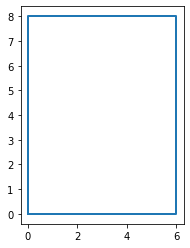

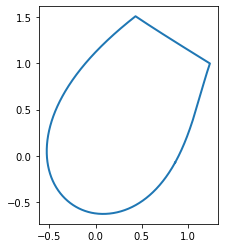

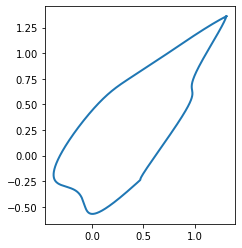

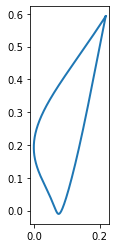

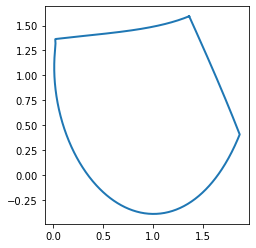

In [1]:
from formes import cercle, rectangle, decaler, transformer, patate

shapes = [
    rectangle(6, 8),
    decaler(patate(3, complexite=4), 0.2, 0.3),
    patate(16, complexite=-1),
    transformer(patate(3, complexite=5), [[0.08194777125807762, 0.09926233405401108], [-0.20573084594207813, 0.7220442168506447]]),
    decaler(patate(15, complexite=5), 0.1, 0.0),
]

for f in shapes:
    f.dessiner()

The problem has the following properties:
* 2 continuous variables: the parameters of the 2 points we are looking for
* A black-box function
* The black-box function is non-convex
* The black-box function is "roughly" differentiable
* An evaluation of the black-box function is cheap


Note that there are no constraint.

We solve the problem with Artelys Knitro using **Knitro Python interface**.

More information about Knitro's Python interface is available here:
* Getting started with the Python interface: https://www.artelys.com/docs/knitro/2_userGuide/gettingStarted/startPython.html
* Python reference manual https://www.artelys.com/docs/knitro/3_referenceManual/knitroPythonReference.html


The non-convexity of the objective function can be seen from the plots above. Indeed, the shapes contain multiple diameters than cannot be improved by infinitesimal changes of the variable values. These diameters all correspond to locally optimal solutions of the problem.

To illustrate this, we solve the problem first with the default configuration of Knitro. By default, Knitro stops as soon as it finds a locally optimal solution.

Then we enable multi-start in Knitro. This option makes Knitro look for multiple locally optimal solutions and increases the chances of finding a globally optimal solution.

Solve the problem without multi-start...
Diameter length: 9.999999877764608


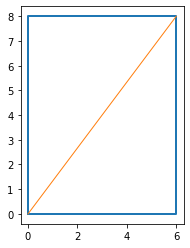

Try again with multi-start...
Diameter length: 9.999999907744025


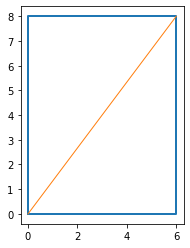

Solve the problem without multi-start...
Diameter length: 2.145362568637217


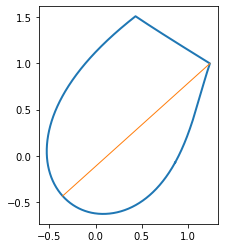

Try again with multi-start...
Diameter length: 2.1802918550616814


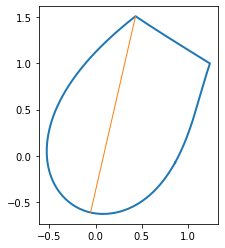

Solve the problem without multi-start...
Diameter length: 2.3201822989263214


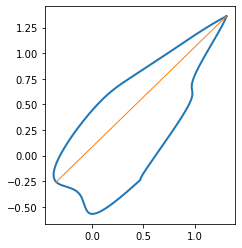

Try again with multi-start...
Diameter length: 2.343937024702363


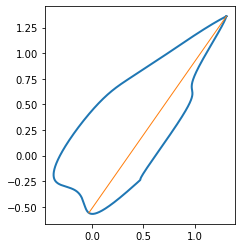

Solve the problem without multi-start...
Diameter length: 0.4599403620216114


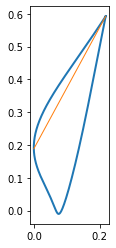

Try again with multi-start...
Diameter length: 0.6198757642272735


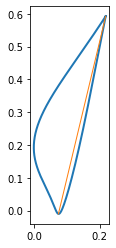

Solve the problem without multi-start...
Diameter length: 2.027603890719662


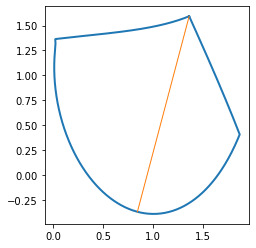

Try again with multi-start...
Diameter length: 2.1313219075483834


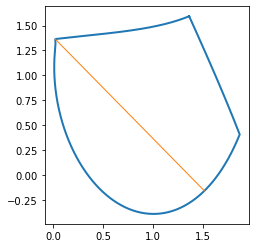

In [5]:
from knitro import *
import math

for f in shapes:

    # Create Knitro object.
    kc = KN_new()

    # Define problem.
    # Add 2 variables.
    KN_add_vars(kc, 2)

    # Set the variable lower bounds to 0.
    KN_set_var_lobnds(kc, None, [0, 0])

    # Set the objective sense to maximization.
    KN_set_obj_goal(kc, KN_OBJGOAL_MAXIMIZE)

    # Add the objective through a callback.
    # Use f.x(t), f.y(t) to get the coordinates of parameter t.
    def callbackEvalF(kc, cb, evalRequest, evalResult, userParams):
        if evalRequest.type != KN_RC_EVALFC:
            return -1
        x = evalRequest.x
        evalResult.obj = math.sqrt(
                (f.x(x[1]) - f.x(x[0]))**2 + (f.y(x[1]) - f.y(x[0]))**2)
        return 0
    KN_add_eval_callback(kc, evalObj=True, funcCallback=callbackEvalF)

    # Solve the problem.
    print("Solve the problem without multi-start...")
    nStatus = KN_solve(kc)

    # Retrieve the solution.
    nStatus, objSol, x, lambda_ = KN_get_solution(kc)

    # Draw the solution.
    print("Diameter length:", objSol)
    f.dessiner([(x[0], x[1])])


    # Try again with multi-start.
    print("Try again with multi-start...")

    # Enable multi-start.
    KN_set_int_param(kc, KN_PARAM_MSENABLE, KN_MS_ENABLE_YES)
    
    # Set a single thread.
    KN_set_int_param(kc, KN_PARAM_NUMTHREADS, 1)

    # Solve the problem.
    nStatus = KN_solve(kc)

    # Retrieve the solution.
    nStatus, objSol, x, lambda_ = KN_get_solution(kc)

    # Draw the solution.
    print("Diameter length:", objSol)
    f.dessiner([(x[0], x[1])])

    # Destroy the Knitro object.
    KN_free(kc)